# WEEK 3
### Table of contents

<ul>
    <li>
        <a href="#1">Preparing DataSet</a>
    </li>
    <li>
        <a href="#2">Data Visualization</a>
    </li>
    <li>
        <a href="#3">Model</a>
    </li>
    
</ul>    

In [1]:
from os.path import dirname, join as pjoin
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from sklearn.preprocessing import normalize 
from scipy.stats.mstats import winsorize

from pprint import pprint

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


%matplotlib inline

window = 240
latency = 0 
channel = 11 - 1 #cz
channels = list(range(64))
freq = 240
lowcut_freq = 0.1
highcut_freq = 20

from scipy.fft import rfft, irfft, rfftfreq,fft,fftfreq,ifft

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, [low, high], btype='band')
    return b,a



def butter_bandpass_filter(data, lowcut = lowcut_freq, highcut = highcut_freq, fs = freq, order=9):
#     b, a = butter_bandpass(lowcut, highcut, fs)
#     y = lfilter(b, a, data)
    f_signal = rfft(data)

    W = rfftfreq(data.size, d=1/freq)
    cut_f_signal = f_signal.copy()
    cut_f_signal[(W>15) ] = 0
    cut_f_signal[(W<0.5) ] = 0

    cut_signal = irfft(cut_f_signal)
    y = cut_signal
    return y

In [2]:
def preprocessing_signal(signal):
    filtered_signal = butter_bandpass_filter(signal,lowcut_freq,highcut_freq,freq,3)
    winsorized_signal = winsorize(filtered_signal,limits=[0.05,0.05])
    return filtered_signal

<a id='1'></a>
## Preparing DataSet

In [3]:
train = scipy.io.loadmat(r'../Data/Subject_A_Train.mat') 
test = scipy.io.loadmat(r'../Data/Subject_A_Test.mat')
test_results = list(open('../Data/true_labels_A.txt','r').read())
train['Signal'].shape

(85, 7794, 64)

In [4]:
Characters = np.array(list(train['TargetChar'][0]))

In [5]:
matrix = np.array([['A','B','C','D','E','F'],['G','H','I','J','K','L'],['M','N','O','P','Q','R'],['S','T','U','V','W','X'],['Y','Z','1','2','3','4'],['5','6','7','8','9','_']])


In [6]:
normalized_train_signal= preprocessing_signal(train['Signal'].ravel()).reshape(train['Signal'].shape[0],train['Signal'].shape[1],train['Signal'].shape[2])
print(normalized_train_signal.shape)
train['Signal'] = scaler.fit_transform(normalized_train_signal)
normalized_test_signal =  preprocessing_signal(test['Signal'].ravel()).reshape(test['Signal'].shape[0],test['Signal'].shape[1],test['Signal'].shape[2])
test['Signal'] =  scaler.transform(normalized_test_signal)

(85, 7794, 64)


ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [ ]:
# arr = np.array([])
# for c in [10]:
#     for epoch in range(train['Signal'].shape[0]):
#         for i in range(1,train['Signal'].shape[1]):
#             if(train['Flashing'][epoch][i] < 0.5 and train['Flashing'][epoch][i-1] > 0.5):
#                 sample = np.array(train['Signal'][epoch][i-24:i+window-24,channel])
                
#                 filteredSample = preprocessing_signal(sample)
#                 arr = np.append(arr,filteredSample)
# pprint(arr)            
# arr = scaler.fit_transform(arr)


In [ ]:
responses = np.array([])

for epoch in range(train['Signal'].shape[0]):
    for i in range(1,train['Signal'].shape[1]):
        if(train['Flashing'][epoch][i] < 0.5 and train['Flashing'][epoch][i-1] > 0.5):
            sample = np.array(train['Signal'][epoch][i-24:i+window-24,channel])

            sample = preprocessing_signal(sample)

            rowcol = train['StimulusCode'][epoch][i-1]
            temp = {'Epoch':epoch+1,'Character':Characters[epoch],'rowcol':rowcol,'Sample':sample,'Isp300':train['StimulusType'][epoch][i-1]}
            responses = np.append(responses,temp)

In [ ]:
def character_in_Row_Col(c,n):
    if n not in (range(1,13)):
        return 0.0
    if n<=6:
        if(c in matrix[:,n-1]):
            return 1.0
        else:
            return 0.0
    else:
        if(c in matrix[n-7]):
            return 1.0
        else:
            return 0.0

In [ ]:
test_responses = np.array([])
for epoch in range(len(test_results)):
    for i in range(1,test['Signal'].shape[1]):
        if(test['Flashing'][epoch][i] < 0.5 and test['Flashing'][epoch][i-1] > 0.5):
            sample = np.array(test['Signal'][epoch][i-24:i+window-24,channel])
            sample = preprocessing_signal(sample)
            rowcol = test['StimulusCode'][epoch][i-1]
            temp = {'Epoch':epoch+1,'Character':test_results[epoch],'rowcol':rowcol,'Sample':sample,'Isp300':character_in_Row_Col(test_results[epoch],int(rowcol))}
            test_responses = np.append(test_responses,temp)

In [ ]:
df = pd.DataFrame(list(responses),columns =['Epoch','Character', 'rowcol','Sample','Isp300'])
df.head()

In [ ]:
df_test = pd.DataFrame(list(test_responses),columns =['Epoch','Character', 'rowcol','Sample','Isp300'])
df_test['Epoch']=df_test['Epoch'] + 85
df_test.head()

In [ ]:
df_all = pd.concat([df,df_test]).reset_index()

<a id='2'></a>
## Data Visualization

In [ ]:
def graphDrawer(df):
    average_p300 = df[df['Isp300']==1]['Sample'].mean()
    average_non_p300 = df[df['Isp300']==0]['Sample'].mean()
    x_axis = np.array(range(window))/240
    plt.plot(x_axis,average_p300,color='#188038',label='P300')
    plt.plot(x_axis,average_non_p300,color='#A1282C',label='Non-P300')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('P300 VS Non-P300')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [19]:
graphDrawer(df)

NameError: name 'graphDrawer' is not defined

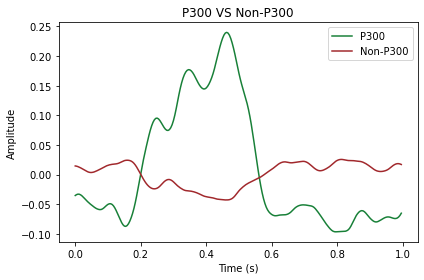

In [116]:
graphDrawer(df_test)

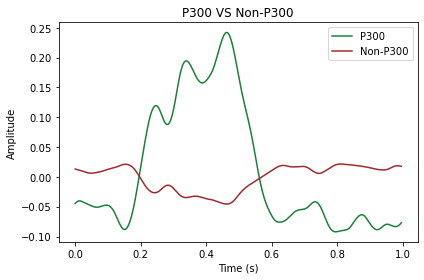

In [117]:
graphDrawer(df_all)

In [118]:
df_all = pd.concat([df_all,pd.DataFrame(list(map(np.ravel, (list(df_all['Sample'])))))],axis=1).drop('index',axis=1)
df = pd.concat([df,pd.DataFrame(list(map(np.ravel, (list(df['Sample'])))))],axis=1)
df_test = pd.concat([df_test,pd.DataFrame(list(map(np.ravel, (list(df_test['Sample'])))))],axis=1)

In [119]:
df_all = df_all.groupby(['Epoch','Character','rowcol','Isp300']).mean().reset_index()

In [120]:
df_test = df_test.groupby(['Epoch','Character','rowcol','Isp300']).mean().reset_index()


In [121]:
df = df.groupby(['Epoch','Character','rowcol','Isp300']).mean().reset_index()


In [122]:
p300_df = df[df['Isp300'] == 1.0].reset_index()
non_p300_df = df[df['Isp300'] == 0.0].reset_index()

In [123]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.utils import shuffle
from sklearn import metrics

In [124]:
def characters_accuracy( clf, df,prob_func=None):
    if(prob_func == None):
        prob_func = clf.decision_function
    res = np.array([])
    for epoch in range(df.min()["Epoch"],df.max()["Epoch"]+1):
        df_epoch = df[df['Epoch']==epoch].reset_index(drop=True)
        if(df_epoch.size == 0):
            continue
        X,_ = prepare_X_y(df_epoch)   
        df_epoch = df_epoch[["Epoch","Character","rowcol","Isp300"]]
        df_epoch['Score'] = prob_func(X)
        row = df_epoch.iloc[6:]['Score'].idxmax()
        col = df_epoch.iloc[:6]['Score'].idxmax()
        predicted_row = df_epoch.iloc[row]['rowcol']
        predicted_col = df_epoch.iloc[col]['rowcol']
        predicted_char = matrix[row-6][col]
        target_char = df_epoch['Character'][0]
        res = np.append(res,{'Epoch':epoch,'Target_Character':target_char,'Predicted_Character':predicted_char,'Predicted_Row':predicted_row,'Predicted_Col':predicted_col,'Same':(target_char==predicted_char)})
        df_res = pd.DataFrame(list(res),columns=['Epoch','Target_Character','Predicted_Character','Predicted_Row','Predicted_Col','Same']) 
    return metrics.accuracy_score(df_res['Target_Character'],df_res['Predicted_Character']) , df_res

In [125]:
def prepare_X_y(temp_df):
    X=temp_df.drop(columns = ['Epoch','Character','rowcol','Isp300'])
    y= temp_df['Isp300']
    return X,y

In [126]:
X_train,y_train = prepare_X_y(df)


X_test,y_test = prepare_X_y(df_test)


df_balanced = pd.concat([df[df['Isp300']==1],df[df['Isp300']==0].sample(170,random_state = 42,ignore_index = True)],ignore_index = True)
X_balanced,y_balanced = prepare_X_y(df_balanced)


In [127]:

svc_unbalanced = svm.SVC(kernel='linear',probability=True)
##clf = GradientBoostingClassifier(n_estimators=10000)
svc_unbalanced.fit(X_train, y_train)
print("Score on training data: {}".format(svc_unbalanced.score(X_train,y_train)))
print("Score on test data: {}".format(svc_unbalanced.score(X_test,y_test)))
# svc_score_train = clf.decision_function(X)
# svc_score_test =clf.predict(X)

Score on training data: 0.8931372549019608
Score on test data: 0.8766666666666667


In [128]:
accuracy , _= characters_accuracy(svc_unbalanced,df)
accuracy
    

0.5764705882352941

In [129]:
accuracy , _= characters_accuracy(svc_unbalanced,df_test)

accuracy

0.46

In [130]:

svc_unbalanced = svm.SVC(kernel='rbf',probability=True)
##clf = GradientBoostingClassifier(n_estimators=10000)
svc_unbalanced.fit(X_train, y_train)
print("Score on training data: {}".format(svc_unbalanced.score(X_train,y_train)))
print("Score on test data: {}".format(svc_unbalanced.score(X_test,y_test)))
# svc_score_train = clf.decision_function(X)
# svc_score_test =clf.predict(X)

Score on training data: 0.9254901960784314
Score on test data: 0.8791666666666667


In [131]:
accuracy , _= characters_accuracy(svc_unbalanced,df)
accuracy
    

0.7294117647058823

In [132]:
accuracy , _= characters_accuracy(svc_unbalanced,df_test)

accuracy

0.49

In [133]:
svc_balanced = svm.SVC(kernel='sigmoid')
svc_balanced.fit(X_balanced, y_balanced)

svc_score_train = svc_balanced.score(X_train, y_train) #Coefficient of determination
svc_score_test =svc_balanced.score(X_test, y_test)

#y_pred=svc.predict(X_test)
print('train score: {}'.format(svc_score_train)) 
print('test score: {}'.format(svc_score_test))


train score: 0.8196078431372549
test score: 0.83


In [134]:
a,_=characters_accuracy(svc_balanced,df)
a

0.43529411764705883

In [135]:
a,_=characters_accuracy(svc_balanced,df_test)
a

0.4

In [136]:
svc_balanced = svm.SVC(kernel='linear')
svc_balanced.fit(X_balanced, y_balanced)

svc_score_train = svc_balanced.score(X_train, y_train) #Coefficient of determination
svc_score_test =svc_balanced.score(X_test, y_test)

#y_pred=svc.predict(X_test)
print('train score: {}'.format(svc_score_train)) 
print('test score: {}'.format(svc_score_test))


train score: 0.8245098039215686
test score: 0.8141666666666667


In [137]:
a,_=characters_accuracy(svc_balanced,df)
a

0.4823529411764706

In [138]:
a,_=characters_accuracy(svc_balanced,df_test)
a

0.43

In [139]:
svc_balanced = svm.SVC(kernel='rbf')
svc_balanced.fit(X_balanced, y_balanced)

svc_score_train = svc_balanced.score(X_train, y_train) #Coefficient of determination
svc_score_test =svc_balanced.score(X_test, y_test)

#y_pred=svc.predict(X_test)
print('train score: {}'.format(svc_score_train)) 
print('test score: {}'.format(svc_score_test))


train score: 0.8519607843137255
test score: 0.8208333333333333


In [140]:
a,_=characters_accuracy(svc_balanced,df)
a

0.6470588235294118

In [141]:
a,_=characters_accuracy(svc_balanced,df_test)
a

0.47

In [142]:
svc_balanced = svm.SVC(kernel='sigmoid')
svc_balanced.fit(X_balanced, y_balanced)

svc_score_train = svc_balanced.score(X_train, y_train) #Coefficient of determination
svc_score_test =svc_balanced.score(X_test, y_test)

#y_pred=svc.predict(X_test)
print('train score: {}'.format(svc_score_train)) 
print('test score: {}'.format(svc_score_test))


train score: 0.8196078431372549
test score: 0.83


In [143]:
a,_=characters_accuracy(svc_balanced,df)
a

0.43529411764705883

In [144]:
a,_=characters_accuracy(svc_balanced,df_test)
a

0.4

## LDA  Linear Discriminant Analysis

In [145]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [146]:
lda_unbalanced = LinearDiscriminantAnalysis()
lda_unbalanced.fit(X_train, y_train)


lda_score_train = lda_unbalanced.score(X_train, y_train) #Coefficient of determination
lda_score_test =lda_unbalanced.score(X_test, y_test)

#y_pred=svc.predict(X_test)
print('train score: {}'.format(svc_score_train)) 
print('test score: {}'.format(svc_score_test))


train score: 0.8196078431372549
test score: 0.83


In [147]:
a,_=characters_accuracy(lda_unbalanced,df)
a

0.7529411764705882

In [148]:
a,_=characters_accuracy(lda_unbalanced,df_test)
a

0.32

## Random Forest

In [149]:
from sklearn.ensemble import RandomForestClassifier

In [150]:
rf = RandomForestClassifier(random_state = 42, n_estimators = 200, min_samples_split = 5, min_samples_leaf =  2, max_features= 'sqrt', max_depth= 90)

rf.fit(X_train, y_train);
rf_score_train = rf.score(X_train, y_train) #Coefficient of determination
rf_score_test =rf.score(X_test, y_test)


#y_pred=svc.predict(X_test)
print('train score: {}'.format(rf_score_train)) 
print('test score: {}'.format(rf_score_test))

train score: 0.9901960784313726
test score: 0.875


In [151]:
Balabizo = lambda x: rf.predict_proba(x)[:,1]
a,_=characters_accuracy(lda_unbalanced,df_test,Balabizo)
a

0.48

In [152]:
rf_balanced = RandomForestClassifier(random_state = 42, n_estimators = 275, min_samples_split = 5, min_samples_leaf =  4, max_features= 'sqrt', max_depth= 40)

rf.fit(X_balanced, y_balanced);
rf_score_train = rf.score(X_train, y_train) #Coefficient of determination
rf_score_test =rf.score(X_test, y_test)


#y_pred=svc.predict(X_test)
print('train score: {}'.format(rf_score_train)) 
print('test score: {}'.format(rf_score_test))

train score: 0.861764705882353
test score: 0.815


In [153]:
Balabizo = lambda x: rf.predict_proba(x)[:,1]
a,_=characters_accuracy(lda_unbalanced,df_test,Balabizo)
a

0.42

In [154]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 7],
 'n_estimators': [200, 275, 350, 425, 500]}


In [155]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_balanced, y_balanced);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [156]:
rf_random.best_params_


{'n_estimators': 200,
 'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [157]:
rf_random.cv_results_


{'mean_fit_time': array([1.49417535, 0.89294434, 0.86518828, 1.11552421, 0.76395655,
        1.56448356, 1.88562481, 1.99067688, 1.72372444, 1.86900226,
        1.06781133, 1.57552361, 2.13668776, 1.2312208 , 2.45481388,
        1.27391807, 2.085814  , 1.96792086, 1.87418795, 1.30072117,
        1.27295979, 1.4047811 , 1.61689115, 1.22610013, 0.93769654,
        1.9122618 , 1.88666685, 1.42572983, 1.95133114, 0.85721684,
        1.43354313, 2.21663499, 1.40462923, 2.96334052, 1.60272582,
        1.14799007, 1.38465405, 2.4706188 , 1.43538737, 1.21330714,
        2.40874441, 1.68184312, 2.381476  , 1.84889936, 1.59240882,
        1.68549283, 2.24333453, 3.19113294, 1.70045296, 2.05550392,
        1.34706473, 1.5688053 , 1.76394955, 2.7782375 , 1.862686  ,
        2.84376216, 2.05955752, 3.26569668, 2.65333517, 2.37438258,
        2.61666894, 3.23302205, 1.10138822, 1.16255848, 2.05317736,
        1.0046467 , 1.22838203, 1.54154468, 1.78805614, 2.5008235 ,
        2.63945301, 2.16538739,

In [262]:
responses = np.array([])

for epoch in range(train['Signal'].shape[0]):
    for i in range(1,train['Signal'].shape[1]):
        if(train['Flashing'][epoch][i] < 0.5 and train['Flashing'][epoch][i-1] > 0.5):
            
            sample = np.array([])
            
            for ch in channels:
                sample = np.append(sample,train['Signal'][epoch][i-24:i+window-24,ch])
            rowcol = train['StimulusCode'][epoch][i-1]
            temp = {'Epoch':epoch+1,'Character':Characters[epoch],'rowcol':rowcol,'Sample':sample,'Isp300':train['StimulusType'][epoch][i-1]}
            responses = np.append(responses,temp)

In [263]:
test_responses = np.array([])
for epoch in range(len(test_results)):
    for i in range(1,test['Signal'].shape[1]):
        if(test['Flashing'][epoch][i] < 0.5 and test['Flashing'][epoch][i-1] > 0.5):
            sample = np.array([])
            for ch in channels:
                sample = np.append(sample,test['Signal'][epoch][i-24:i+window-24,channel])
            rowcol = test['StimulusCode'][epoch][i-1]
            temp = {'Epoch':epoch+1,'Character':test_results[epoch],'rowcol':rowcol,'Sample':sample,'Isp300':character_in_Row_Col(test_results[epoch],int(rowcol))}
            test_responses = np.append(test_responses,temp)

In [283]:
df_extended = pd.DataFrame(list(responses),columns =['Epoch','Character', 'rowcol','Sample','Isp300'])
df_extended.head()

,Epoch,Character,rowcol,Sample,Isp300
0,1,E,12.0,"[0.08084999769926071, -2.2476298809051514, 7.5...",0.0
1,1,E,11.0,"[4.737810134887695, 12.499409675598145, 12.758...",0.0
2,1,E,3.0,"[2.1506099700927734, 7.066289901733398, 11.205...",0.0
3,1,E,10.0,"[2.6680500507354736, 8.87732982635498, 14.8278...",0.0
4,1,E,9.0,"[-18.029550552368164, -14.924909591674805, -8....",0.0


In [284]:
df_extended = pd.concat([df_extended,pd.DataFrame(list(map(np.ravel, (list(df_extended['Sample'])))))],axis=1)
df_extended

,Epoch,Character,rowcol,Sample,Isp300,0,1,2,3,4,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,1,E,12.0,"[0.08084999769926071, -2.2476298809051514, 7.5...",0.0,0.080850,-2.24763,7.583730,0.080850,-7.680750,...,-5.69374,-2.648620,-2.141100,-6.201260,-6.96254,-1.88734,-3.40990,-8.48510,-10.00766,-6.70878
1,1,E,11.0,"[4.737810134887695, 12.499409675598145, 12.758...",0.0,4.737810,12.49941,12.758130,0.080850,-6.128430,...,1.91906,0.142740,1.919060,3.187860,1.66530,-0.61854,-0.36478,5.21794,5.97922,-0.87230
2,1,E,3.0,"[2.1506099700927734, 7.066289901733398, 11.205...",0.0,2.150610,7.06629,11.205810,3.185490,-4.834830,...,-14.06782,-13.306540,-10.007660,-12.037740,-14.06782,-13.05278,-12.54526,-14.06782,-13.05278,-11.27646
3,1,E,10.0,"[2.6680500507354736, 8.87732982635498, 14.8278...",0.0,2.668050,8.87733,14.827890,4.996530,-6.645870,...,-8.73886,-8.485100,-6.962540,-7.977580,-8.48510,-6.20126,-3.66366,-4.17118,-6.45502,-5.43998
4,1,E,9.0,"[-18.029550552368164, -14.924909591674805, -8....",0.0,-18.029551,-14.92491,-8.198190,-11.561550,-13.113870,...,-7.47006,-4.171180,-5.947500,-9.753900,-8.48510,-6.45502,-8.73886,-10.51518,-8.48510,-9.24638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15295,85,I,2.0,"[-11.56155014038086, -12.85515022277832, -13.3...",0.0,-11.561550,-12.85515,-13.372590,-14.924910,-18.288271,...,-5.69374,-6.708780,-6.708780,-1.887340,2.17282,0.14274,-3.66366,-3.40990,-5.18622,-9.50014
15296,85,I,3.0,"[-14.407469749450684, -15.183629989624023, -19...",1.0,-14.407470,-15.18363,-19.323151,-20.099310,-16.477230,...,0.65026,3.441620,1.411540,-1.887340,1.15778,6.23298,4.20290,-2.14110,-1.63358,3.44162
15297,85,I,12.0,"[-12.07898998260498, -12.596429824829102, -10....",0.0,-12.078990,-12.59643,-10.009230,-10.785390,-14.924910,...,27.04130,35.415379,36.176659,31.355221,17.65218,2.17282,-2.90238,0.14274,1.15778,-2.14110
15298,85,I,8.0,"[-14.407469749450684, -13.63131046295166, -15....",1.0,-14.407470,-13.63131,-15.442350,-13.113870,-6.904590,...,-5.18622,4.964180,10.800660,7.501780,5.72546,12.57698,16.12962,7.50178,1.91906,7.75554


In [285]:
df_extended = df_extended.groupby(['Epoch','Character','rowcol','Isp300']).mean().reset_index()
df_extended

,Epoch,Character,rowcol,Isp300,0,1,2,3,4,5,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,1,E,1.0,0.0,-1.816430,0.546546,1.357202,1.305458,0.253330,-0.264110,...,-0.026433,-0.635457,0.498004,0.464169,-1.024556,-2.107265,-0.161772,0.667177,-1.024556,-1.633580
1,1,E,2.0,0.0,-1.212750,-0.195118,-0.471086,-2.678830,-4.231150,-1.540462,...,-2.005761,-3.088471,-2.242604,-1.565911,-2.597868,-3.139223,-1.735084,0.193492,1.123945,2.663423
2,1,E,3.0,0.0,-1.436974,-1.350734,0.270578,-0.522830,-0.764302,0.529298,...,-0.686209,-0.533953,0.091988,-0.483201,-0.939969,-0.500119,0.954772,2.138985,1.665300,1.157780
3,1,E,4.0,0.0,0.046354,0.788018,-1.609454,-2.661582,-4.334638,-4.110414,...,1.073193,2.967935,3.272447,2.545001,1.310036,1.242367,0.599508,-0.584705,0.159657,2.054399
4,1,E,5.0,1.0,-2.644334,-2.213134,-0.160622,-1.161006,-1.229998,-1.316238,...,0.362665,-0.026433,0.582591,2.341993,4.236735,4.608916,2.866431,1.445375,1.597631,1.749887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,85,I,8.0,1.0,-5.645486,-6.076686,-6.369902,-6.594126,-5.990446,-5.197038,...,-2.107265,-1.921175,-1.464407,-1.667415,-2.174935,-1.735084,-0.855383,-1.227564,-2.225687,-2.614785
1016,85,I,9.0,0.0,-1.023022,-0.712558,-0.246862,-0.971278,-1.937166,-1.937166,...,2.934100,1.919060,2.663423,3.627711,2.511167,1.107028,1.749887,3.204777,2.866431,2.122068
1017,85,I,10.0,0.0,3.306226,3.495954,3.340722,4.203122,5.600210,4.962034,...,1.969812,3.644628,3.796884,2.866431,2.917183,3.830719,3.441620,1.479209,-0.026433,-0.449367
1018,85,I,11.0,0.0,0.098098,-0.229614,-0.298606,-1.264494,-2.023406,-1.178254,...,-1.582828,-1.870423,-1.870423,-1.616663,-1.396737,-1.295233,-0.432449,1.885225,3.526207,3.137108


In [286]:
df_extended_test = pd.DataFrame(list(test_responses),columns =['Epoch','Character', 'rowcol','Sample','Isp300'])
df_extended_test.head()

,Epoch,Character,rowcol,Sample,Isp300
0,1,W,8.0,"[-21.84160041809082, -24.41119956970215, -26.2...",0.0
1,1,W,4.0,"[-28.265600204467773, -25.952959060668945, -28...",0.0
2,1,W,6.0,"[-10.535360336303711, -12.33407974243164, -14....",0.0
3,1,W,2.0,"[-18.50111961364746, -18.244159698486328, -14....",0.0
4,1,W,7.0,"[-14.132800102233887, -19.528959274291992, -24...",0.0


In [287]:
df_extended_test = pd.concat([df_extended_test,pd.DataFrame(list(map(np.ravel, (list(df_extended_test['Sample'])))))],axis=1)
df_extended_test

,Epoch,Character,rowcol,Sample,Isp300,0,1,2,3,4,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,1,W,8.0,"[-21.84160041809082, -24.41119956970215, -26.2...",0.0,-21.841600,-24.411200,-26.209921,-25.695999,-23.126400,...,-20.042879,-11.563200,-4.62528,-6.167040,-8.222720,-8.479680,-7.194880,-9.507520,-10.792320,-7.194880
1,1,W,4.0,"[-28.265600204467773, -25.952959060668945, -28...",0.0,-28.265600,-25.952959,-28.008640,-33.661758,-36.231361,...,-11.563200,-14.903680,-14.38976,-9.507520,-12.334080,-18.501120,-14.903680,-10.021440,-8.993600,-7.708800
2,1,W,6.0,"[-10.535360336303711, -12.33407974243164, -14....",0.0,-10.535360,-12.334080,-14.646720,-14.903680,-14.389760,...,-11.306240,-12.591040,-12.33408,-13.618880,-15.417600,-13.618880,-6.424000,-1.798720,-3.083520,-4.111360
3,1,W,2.0,"[-18.50111961364746, -18.244159698486328, -14....",0.0,-18.501120,-18.244160,-14.132800,-13.875840,-15.674560,...,1.541760,-3.854400,-5.91008,-2.826560,-1.027840,-2.312640,-3.854400,-2.569600,-1.541760,-6.424000
4,1,W,7.0,"[-14.132800102233887, -19.528959274291992, -24...",0.0,-14.132800,-19.528959,-24.925119,-23.383360,-18.244160,...,-15.931520,-15.160640,-12.84800,-13.875840,-16.959360,-20.556801,-20.299841,-17.987200,-15.931520,-14.903680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,100,U,4.0,"[-2.5696001052856445, -1.2848000526428223, -2....",0.0,-2.569600,-1.284800,-2.826560,-4.368320,-3.854400,...,2.569600,-1.284800,0.25696,4.882240,2.312640,-1.541760,0.256960,1.798720,-1.541760,-3.854400
17996,100,U,10.0,"[-16.188480377197266, -19.528959274291992, -15...",1.0,-16.188480,-19.528959,-15.160640,-10.278400,-10.278400,...,-11.820160,-4.882240,-2.31264,-6.167040,-6.680960,-5.396160,-6.680960,-8.479680,-8.736640,-7.965760
17997,100,U,3.0,"[-16.70240020751953, -15.160639762878418, -17....",1.0,-16.702400,-15.160640,-17.216320,-17.987200,-14.132800,...,33.661758,34.689602,34.43264,35.717442,36.488319,37.259201,41.113602,46.509762,52.419842,60.128639
17998,100,U,8.0,"[-12.591039657592773, -18.50111961364746, -19....",0.0,-12.591040,-18.501120,-19.015039,-15.674560,-17.216320,...,26.723841,22.098560,14.90368,8.736640,5.653120,5.910080,4.111360,3.597440,6.937920,10.278400


In [288]:
df_extended_test = df_extended_test.groupby(['Epoch','Character','rowcol','Isp300']).mean().reset_index()
df_extended_test

,Epoch,Character,rowcol,Isp300,0,1,2,3,4,5,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,1,W,1.0,0.0,4.573888,3.374741,3.391872,4.351189,4.710933,2.758037,...,2.552469,2.535339,2.535339,2.518208,1.558891,1.147755,1.301931,1.781589,2.141333,2.432555
1,1,W,2.0,0.0,1.627413,0.548181,0.222699,-0.274091,-0.616704,0.102784,...,9.815872,10.278400,11.426155,10.586752,8.085675,7.349056,8.102805,8.445419,7.760192,6.167040
2,1,W,3.0,0.0,-1.832981,-2.569600,-3.014997,-1.524629,0.342613,-0.034261,...,1.507499,2.175595,2.706645,1.353323,0.839403,0.548181,0.017130,-0.394005,-0.017131,1.918635
3,1,W,4.0,0.0,-2.415424,-0.788011,-0.531051,-2.586731,-3.974315,-3.528917,...,-1.027840,-0.788011,0.017131,0.753749,1.062101,0.770880,1.182016,2.398293,3.134912,2.449685
4,1,W,5.0,1.0,-1.147754,-1.062101,-1.216277,-1.336192,-0.736619,-0.445397,...,-1.182016,-1.164885,-2.038549,-2.364032,-2.175595,-2.295509,-1.627413,-0.154176,0.017131,-0.479659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,100,U,8.0,0.0,2.004288,1.079232,0.599573,1.233408,1.850112,1.832981,...,2.603861,2.689515,3.871531,4.265536,2.980736,1.935765,2.158464,1.867243,0.685227,0.805141
1196,100,U,9.0,0.0,4.334059,3.083520,3.511787,3.803008,2.603861,1.952896,...,0.154176,1.182016,0.599573,-0.154176,-0.102784,-0.633835,-1.850112,-2.792299,-1.490368,-0.616704
1197,100,U,10.0,1.0,1.370453,0.102784,0.959317,1.267669,0.668096,0.942187,...,-2.775168,-0.873664,-0.890794,-0.565312,1.421845,2.758037,1.713067,1.182016,2.963605,3.546048
1198,100,U,11.0,0.0,8.274112,9.695957,10.295531,9.216299,8.496811,7.914368,...,1.319061,0.770880,-0.873664,-1.832981,-2.278379,-2.758037,-2.449685,-1.644544,-0.976448,-0.788011


In [289]:
X,y = prepare_X_y(df_extended)
##Splitting Data set to train and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

start = time.perf_counter()

clf = svm.SVC(kernel='linear')
##clf = GradientBoostingClassifier(n_estimators=10000)
clf.fit(X_train, y_train)

svc_score_train = clf.score(X_train, y_train) #Coefficient of determination
svc_score_test =clf.score(X_test, y_test)
#y_pred=svc.predict(X_test)

print('train score: {}'.format(svc_score_train)) 
print('test score: {}'.format(svc_score_test))

end = time.perf_counter()
print(end - start)

train score: 1.0
test score: 0.9313725490196079
3.9516756999983045


In [290]:
characters_accuracy(clf,df_extended)

,Character,P300,Non_P300,Total
0,A,1.000000,0.950000,0.958333
1,B,0.833333,1.000000,0.972222
2,C,0.833333,1.000000,0.972222
3,D,1.000000,0.975000,0.979167
4,E,0.937500,0.962500,0.958333
5,F,1.000000,1.000000,1.000000
6,G,1.000000,1.000000,1.000000
7,H,1.000000,0.975000,0.979167
8,I,1.000000,0.966667,0.972222
9,J,1.000000,1.000000,1.000000


In [291]:
df_extended_balanced = pd.concat([df_extended[df_extended['Isp300']==1],df_extended[df_extended['Isp300']==0].sample(170,random_state = 42,ignore_index = True)],ignore_index = True)
df_extended_balanced

,Epoch,Character,rowcol,Isp300,0,1,2,3,4,5,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,1,E,5.0,1.0,-2.644334,-2.213134,-0.160622,-1.161006,-1.229998,-1.316238,...,0.362665,-0.026433,0.582591,2.341993,4.236735,4.608916,2.866431,1.445375,1.597631,1.749887
1,1,E,7.0,1.0,1.063986,-3.075534,-3.127278,-1.178254,0.736274,1.184722,...,4.761172,4.101396,4.422825,4.761172,4.253652,3.864553,3.915305,3.796884,1.935977,0.261161
2,2,A,1.0,1.0,2.202354,1.253714,0.167090,1.184722,2.047122,0.839762,...,-0.009516,0.701012,1.259284,1.259284,1.107028,0.819433,0.684095,0.565673,0.193492,0.244244
3,2,A,7.0,1.0,1.201970,-0.177870,-1.678446,-0.298606,1.771154,1.529682,...,-1.075308,0.261161,-0.229441,-1.159895,-0.855383,-0.111020,-0.398615,-1.261399,-1.532076,-1.278316
4,3,E,5.0,1.0,-3.851694,-6.611374,-8.163694,-5.679982,-3.472238,-2.558094,...,-1.887340,0.481087,-1.752001,-5.000129,-3.866668,-0.618540,-1.142977,-2.225687,0.582591,3.560041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,30,H,9.0,0.0,2.702546,3.564946,5.669202,4.841299,2.961266,3.013010,...,8.449150,8.093887,9.887124,11.088255,10.039380,9.768702,11.900286,13.355177,11.798783,9.819455
336,16,O,7.0,0.0,0.857010,1.201970,2.530066,1.719410,0.494802,1.719410,...,4.828841,3.035604,3.441620,4.439743,4.338239,3.475455,3.560041,4.744255,4.879593,4.676585
337,33,M,8.0,0.0,-3.334254,-3.541230,-3.127278,-3.523982,-5.041806,-5.679982,...,-1.210647,-3.105388,-4.238849,-3.917420,-3.900503,-5.067799,-5.812161,-5.609153,-5.845996,-6.945623
338,11,8,2.0,0.0,-15.476846,-10.009230,-5.179790,-0.471086,1.512435,2.616306,...,26.144682,25.857087,28.073257,28.919124,28.056341,30.577022,32.488681,27.464233,17.093908,16.248041


In [292]:
X,y = prepare_X_y(df_extended_balanced)


clf2 = svm.SVC(kernel='linear')
##clf = GradientBoostingClassifier(n_estimators=10000)
clf2.fit(X,y)

svc_score_train = clf2.score(X, y) #Coefficient of determination
#y_pred=svc.predict(X_test)

print('train score: {}'.format(svc_score_train)) 
X,y = prepare_X_y(df_extended)
print('test score: {}'.format(clf2.score(X, y))) 


train score: 1.0
test score: 0.942156862745098


In [293]:
characters_accuracy(clf2,df_extended)

,Character,P300,Non_P300,Total
0,A,1.0,0.950000,0.958333
1,B,1.0,0.966667,0.972222
2,C,1.0,0.833333,0.861111
3,D,1.0,0.975000,0.979167
4,E,1.0,0.937500,0.947917
5,F,1.0,0.850000,0.875000
6,G,1.0,0.950000,0.958333
7,H,1.0,0.950000,0.958333
8,I,1.0,1.000000,1.000000
9,J,1.0,1.000000,1.000000


In [296]:
X,y = prepare_X_y(df_extended_test)
print('test score: {}'.format(clf2.score(X, y))) 


test score: 0.8441666666666666


In [299]:
characters_accuracy(clf2,df_extended_test)

,Character,P300,Non_P300,Total
0,A,1.000000,0.166667,0.305556
1,B,1.000000,0.300000,0.416667
2,C,1.000000,0.200000,0.333333
3,D,0.916667,0.366667,0.458333
4,E,1.000000,0.212500,0.343750
5,F,1.000000,0.200000,0.333333
6,G,1.000000,0.366667,0.472222
7,H,0.750000,0.150000,0.250000
8,I,0.750000,0.400000,0.458333
9,J,0.833333,0.133333,0.250000


In [27]:

# importing pandas as pd
  
# Creating the dataframe 
df = pd.DataFrame({"A":[12, 4, 5, 44, 1],
                   "B":[5, 2, 54, 3, 2],
                   "C":[20, 16, 7, 3, 8], 
                   "D":[14, 3, 17, 2, 6]})
  
# Print the dataframe
df

,A,B,C,D
0,12,5,20,14
1,4,2,16,3
2,5,54,7,17
3,44,3,3,2
4,1,2,8,6


In [31]:
df.max(axis = 0)


A    44
B    54
C    20
D    17
dtype: int64

In [29]:
df.max(axis = 0, level = "A")

C:\Users\ahmad\AppData\Local\Temp/ipykernel_4852/1374168497.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df.max(axis = 0, level = "A")


ValueError: level name A is not the name of the index

In [29]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band',fs = fs)
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=9):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def run():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0
    highcut = 1250.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = int(T * fs)
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    print(type(y))
    print(x.shape)
    print(y.shape)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()

<class 'numpy.ndarray'>
(250,)
(250,)


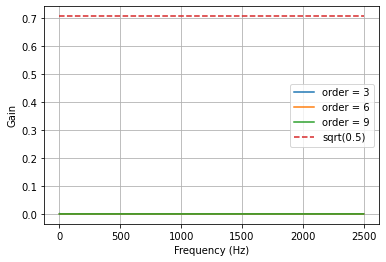

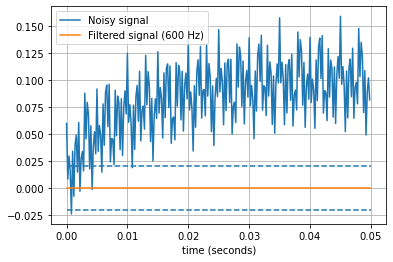

In [30]:
run()

In [8]:
x= np.array([1,2,3])
y = np.array([1,2,3])

In [12]:
np.vstack([x,y])

array([[1, 2, 3],
       [1, 2, 3]])

In [5]:
x.ravel()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
x.ravel().reshape(3,3)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import pi
from scipy.fft import fft

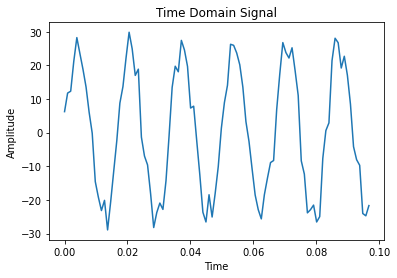

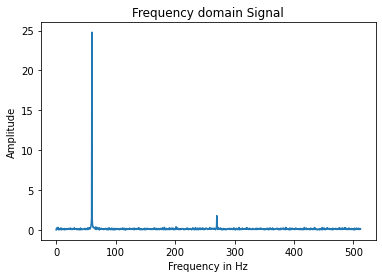

In [10]:
sample_rate = 1024
N = (2 - 0) * sample_rate
time = np.linspace(0, 2, N)

freq1 = 60
magnitude1 = 25
freq2 = 270
magnitude2 = 2

waveform1 = magnitude1 * np.sin (2 * pi * freq1 * time)
waveform2 = magnitude2 * np.sin (2 * pi * freq2 * time)

noise = np.random.normal (0, 3, N)

time_data = waveform1 + waveform2 + noise

plt.plot (time [0:100], time_data [0:100])
plt.title ('Time Domain Signal')
plt.xlabel ('Time')
plt.ylabel ('Amplitude')
plt.show ()

frequency = np.linspace (0.0, 512, int (N/2))

freq_data = fft(time_data)
y = 2/N * np.abs (freq_data [0:int (N/2)])

plt.plot(frequency, y)
plt.title('Frequency domain Signal')
plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude')
plt.show()

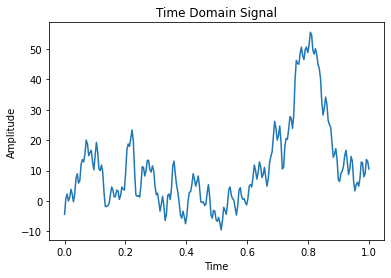

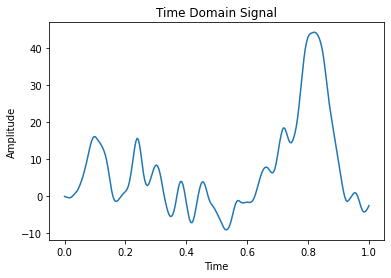

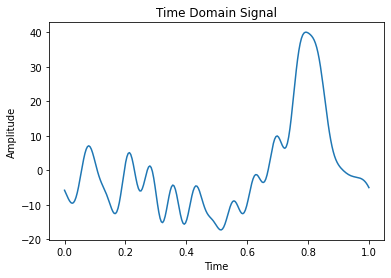

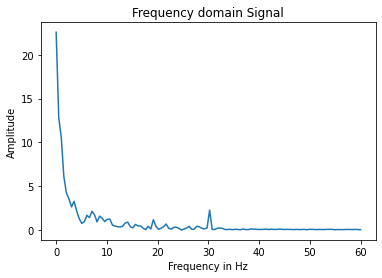

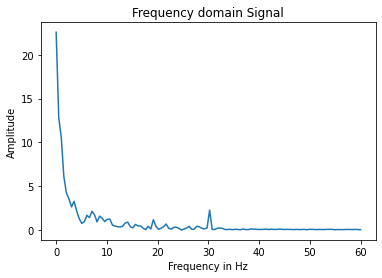

0.0041841004184100415
0.004166666666666667


In [72]:
from scipy.fft import rfft, irfft, rfftfreq,fft,fftfreq,ifft

signal = train['Signal'][1][7542-24:7542+window-24,channel]
N = (1-0) * freq
time = np.linspace(0,1,N)

plt.plot (time, signal)
plt.title ('Time Domain Signal')
plt.xlabel ('Time')
plt.ylabel ('Amplitude')
plt.show()



plt.plot (time, preprocessing_signal(signal))
plt.title ('Time Domain Signal')
plt.xlabel ('Time')
plt.ylabel ('Amplitude')
plt.show()


f_signal = rfft(signal)

W = rfftfreq(signal.size, d=1/240)
cut_f_signal = f_signal.copy()
cut_f_signal[(W>15) ] = 0
cut_f_signal[(W<0.5) ] = 0

cut_signal = irfft(cut_f_signal)

plt.plot (time, cut_signal)
plt.title ('Time Domain Signal')
plt.xlabel ('Time')
plt.ylabel ('Amplitude')
plt.show()



frequency = np.linspace (0.0, 60, int (N/2))
freq_data = rfft(signal)
y = 2/N * np.abs (freq_data [0:int (N/2)])

plt.plot(frequency, y)
plt.title('Frequency domain Signal')
plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude')
plt.show()



f_signal = fft(signal)
y = 2/N * np.abs (f_signal [0:int (N/2)])
plt.plot(frequency, y)
plt.title('Frequency domain Signal')
plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude')
plt.show()

print(time[1]-time[0])
print(1/240)


In [6]:
f_signal = rfft(signal)

W = rfftfreq(signal.size, d=1/240)
W2 = rfftfreq(signal.size, d=time[1]-time[0])
cut_f_signal = f_signal.copy()
cut_f_signal[(W>30) ] = 0
cut_f_signal[(W<0.5) ] = 0

cut_f_signal2 = f_signal.copy()
cut_f_signal2[(W>30) ] = 0
cut_f_signal2[(W<0.5) ] = 0

cut_signal = irfft(cut_f_signal)
cut_signal2 = irfft(cut_f_signal)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


IndexError: GridSpec slice would result in no space allocated for subplot

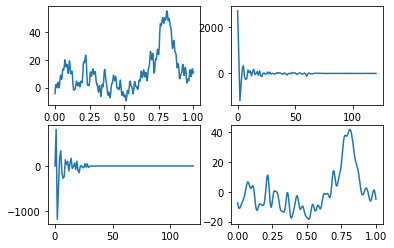

In [12]:
import pylab as plt
plt.subplot(221)
plt.plot(time,signal)
plt.subplot(222)
plt.plot(W,f_signal)
plt.subplot(223)
plt.plot(W,cut_f_signal)
plt.subplot(224)
plt.plot(time,cut_signal)
plt.subplot(219)
plt.plot(W2,cut_f_signal2)
plt.subplot(220)
plt.plot(time,cut_signal2)
plt.show()

In [191]:
f_signal = fft(signal)

W = fftfreq(signal.size, d=time[1]-time[0])

cut_f_signal = f_signal.copy()
cut_f_signal[(W>30) ] = 0
cut_f_signal[(W<0.5) ] = 0

cut_signal = ifft(cut_f_signal)

In [1]:
plt.subplot(221)
plt.plot(time,signal)
plt.subplot(222)
plt.plot(W,f_signal)
plt.subplot(223)
plt.plot(W,cut_f_signal)
plt.subplot(224)
plt.plot(time,cut_signal)
plt.figsize(10,12)
plt.show()

NameError: name 'plt' is not defined

In [174]:
import numpy as np
from scipy.fft import rfft, irfft, rfftfreq

time   = np.linspace(0,10,2000)
signal = np.cos(5*2*np.pi*time) + np.cos(7*2*np.pi*time)

W = rfftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal = f_signal.copy()
cut_f_signal[(W<30)] = 0

cut_signal = irfft(cut_f_signal)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


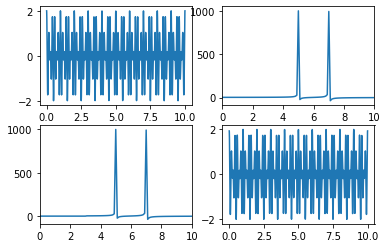

In [141]:
import pylab as plt
plt.subplot(221)
plt.plot(time,signal)
plt.subplot(222)
plt.plot(W,f_signal)
plt.xlim(0,10)
plt.subplot(223)
plt.plot(W,cut_f_signal)
plt.xlim(0,10)
plt.subplot(224)
plt.plot(time,cut_signal)
plt.show()